In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
import keras
from keras import optimizers

from sys import path
path.insert(0, '/content/drive/My Drive/KSL-translator/library/')

from preprocessing import delete_face
from preprocessing import minimize_face
from preprocessing import split_in_blocks
import normalization
import augmentation
from get_data import get_y
import SLT_model

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [13]:
# Useful Constants

own_added = False

n_steps = 50

augmentation_amount = 50

normalization_method = "standard"

#0: without face, 1: minimize_face, 2:include all face points
what_about_face = 1

do_set_standard_point = False

if own_added:
  data_path = "/content/drive/My Drive/KSL-translator/data/KETI_added_own/"
else:
  data_path = "/content/drive/My Drive/KSL-translator/data/KETI/"

X_train_path = data_path + "X_train_og.csv"
X_test_path = data_path + "X_test_og.csv"

Y_train_path = data_path + "Y_train_amount.csv"
Y_test_path = data_path + "Y_test_amount.csv"

In [14]:
X_train = pd.read_csv(X_train_path, header=None)
X_test = pd.read_csv(X_test_path, header=None)

In [15]:
col_list = ["file", "type", "file_name", "amount", "cumulative_sum"]
Y_train = pd.read_csv(Y_train_path, usecols=col_list)
Y_test = pd.read_csv(Y_test_path, usecols=col_list)

##Without face?

In [16]:
if what_about_face == 0:
  X_train = delete_face(X_train.values.tolist())
  X_test = delete_face(X_test.values.tolist())
elif what_about_face == 1:
  X_train = minimize_face(X_train.values.tolist())
  X_test = minimize_face(X_test.values.tolist())

In [17]:
X_train.shape

(56910, 156)

##Normalization

In [18]:
normalization_model_base_path = '/content/drive/My Drive/KSL-translator/model/'
normalization_model_name = normalization_method+'_norm_model.pkl'

normalization_model_path = normalization_model_base_path + normalization_model_name

In [19]:
X_train, X_test = normalization.norm(X_train, normalization_method, normalization_model_path, do_set_standard_point, what_about_face, X_test)

Empty DataFrame
Columns: []
Index: []
        nose_x   neck_x  r_shoulder_x  ...  r_hand_18_x  r_hand_19_x  r_hand_20_x
0      635.232  635.284       480.521  ...      472.348      475.793      474.415
1      635.236  635.258       480.537  ...      472.076      474.828      473.452
2      635.258  637.193       484.382  ...      472.725      474.780      473.410
3      635.261  637.188       482.479  ...      440.182      477.086      473.605
4      635.263  635.322       482.438  ...      473.517      475.630      474.222
...        ...      ...           ...  ...          ...          ...          ...
12510  603.987  556.838       400.200  ...      321.194      324.416      336.499
12511  604.004  556.847       400.184  ...      323.404      332.285      333.900
12512  604.008  556.873       400.177  ...      321.636      324.850      318.421
12513  605.835  556.824       400.170  ...      326.796      339.460      337.877
12514  605.855  556.870       400.173  ...      332.105     

In [20]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155
0,0.247602,0.372837,0.025846,0.008005,-0.648366,0.780118,0.066854,0.393147,0.283467,0.344088,0.591677,0.496120,0.315396,0.303808,0.340860,0.356394,0.351245,0.311912,0.380999,0.430540,0.418178,0.429838,0.417878,0.425589,0.257499,0.266903,0.256521,0.250217,0.274316,0.319833,0.382784,0.321511,0.270713,0.259322,0.279204,0.241684,0.449256,0.400980,0.801642,0.569385,...,0.836080,0.922847,0.903941,0.910971,0.900557,0.894822,0.930147,1.001339,0.919028,0.922918,0.924098,1.005166,0.917784,0.953275,0.941258,1.051679,0.960779,0.999973,1.009174,1.440124,1.466339,1.359404,1.323613,1.310499,1.268628,1.291854,1.297089,1.325859,1.349743,1.302790,1.302145,1.301672,1.355407,1.299774,1.310123,1.323603,1.367024,1.281771,1.376107,1.391176
1,0.247564,0.369642,-0.021815,-0.049603,-0.648025,0.739306,0.095530,0.406668,0.283467,0.379141,0.592710,0.504687,0.303330,0.308707,0.347810,0.364924,0.358212,0.301327,0.382145,0.418302,0.422612,0.435678,0.422315,0.428621,0.233242,0.245267,0.267286,0.262134,0.287610,0.319889,0.400062,0.336833,0.284106,0.271305,0.274720,0.234938,0.462256,0.503295,0.800554,0.554843,...,0.834663,0.941097,0.896272,0.886865,0.909966,0.899526,0.934013,1.006872,0.924312,0.927209,0.936056,1.010704,0.927463,0.969673,0.961204,1.170376,1.018913,1.029008,1.025041,1.435708,1.459084,1.348267,1.312583,1.300043,1.245403,1.292647,1.286942,1.308769,1.342556,1.292012,1.288258,1.295831,1.340063,1.284902,1.304104,1.329507,1.484226,1.242318,1.398145,1.393805
2,0.211953,0.371796,-0.022063,-0.079561,-0.647739,0.780731,0.183671,0.406225,0.246003,0.343411,0.592306,0.495900,0.294547,0.315421,0.339089,0.356182,0.349469,0.323561,0.404001,0.424859,0.413897,0.426966,0.413593,0.419906,0.240044,0.251935,0.258651,0.253554,0.263959,0.341613,0.375964,0.343407,0.260279,0.262678,0.266055,0.226187,0.470263,0.467364,0.792003,0.583051,...,0.836426,0.917322,0.889097,0.890788,0.903117,0.887991,0.909116,0.999747,0.913161,0.898316,0.910472,1.003369,0.916049,0.922866,0.930505,1.026092,0.927876,1.017261,1.025457,1.405108,1.452617,1.206855,1.286952,1.302565,1.249060,1.310240,1.310079,1.347425,1.372764,1.295230,1.335835,1.322832,1.366613,1.295659,1.328306,1.346845,1.436123,1.388606,1.388085,1.398152
3,0.213011,0.370352,-0.022411,-0.222690,-0.539476,0.739285,0.299165,0.337830,0.282110,0.379498,0.592687,0.495991,0.310053,0.314745,0.353027,0.354141,0.363442,0.307442,0.414023,0.434238,0.422726,0.420062,0.422429,0.429288,0.223077,0.219059,0.255703,0.250160,0.260080,0.276366,0.370562,0.293022,0.256371,0.244134,0.232715,0.224144,0.465072,0.471009,0.456616,0.512352,...,0.973178,0.892795,0.860435,0.888778,0.894338,0.886155,0.890406,0.998901,0.912345,0.899582,0.902452,1.014924,0.915064,0.911186,0.975153,1.028645,0.885740,1.026144,1.033501,1.170358,1.464110,1.403898,1.291616,1.189154,1.352232,1.320631,1.114784,1.080529,1.238141,1.259234,1.196094,1.331148,1.233857,1.218616,1.254912,1.252307,1.277041,1.009758,1.264745,1.253384
4,0.211708,0.370730,0.026566,-0.223514,-0.508166,0.738820,0.328987,0.296750,0.245334,0.378877,0.593047,0.478151,0.292565,0.297114,0.335085,0.335964,0.330074,0.289794,0.409785,0.414565,0.402841,0.415116,0.402528,0.409608,0.204918,0.200882,0.237348,0.231756,0.241476,0.272480,0.351004,0.289077,0.252747,0.240759,0.214375,0.190587,0.339099,0.593520,0.290805,0.425503,...,1.035801,0.985159,0.732614,1.014551,0.619025,0.659060,0.632825,0.882287,0.669259,0.739763,0.919963,0.888253,0.797127,0.907227,0.882608,0.850984,0.747372,0.910936,0.903205,1.046458,1.040742,0.951175,1.088758,1.350533,0.919745,1.036114,1.005622,0.966411,1.075961,1.120976,0.982234,1.088221,1.065585,1.104075,1.064387,1.056682,0.923112,0.874241,1.073695,1.063481


In [21]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155
0,-0.381338,0.000549,-0.215587,0.151134,-0.600953,0.325349,-0.137748,0.282851,-0.331392,-0.284695,-0.067983,0.298276,-0.299881,-0.307849,-0.304166,-0.318533,-0.295376,-0.301669,-0.301882,-0.311080,-0.282514,-0.284879,-0.283388,-0.316323,-0.328109,-0.358506,-0.353123,-0.366775,-0.369351,-0.360637,-0.310521,-0.362555,-0.364325,-0.361085,-0.373075,-0.339847,0.345328,0.222695,0.452515,0.318575,...,1.076696,0.855659,0.965664,0.907355,0.905822,0.918330,0.917274,0.835793,0.866315,0.837944,0.752656,0.800979,0.829454,0.829543,0.780499,0.770683,0.764481,0.697999,0.832329,1.098275,1.077729,1.392219,1.374499,1.361936,1.271847,1.353270,1.351931,1.355079,1.210483,1.102198,1.337822,1.322574,1.229076,1.088827,0.981224,0.935512,1.232273,1.029078,0.952254,0.946004
1,-0.381262,-0.000066,-0.215190,0.151516,-0.585960,0.325074,-0.164982,0.282478,-0.331628,-0.284733,-0.067826,0.298253,-0.300075,-0.294345,-0.304320,-0.318668,-0.295530,-0.301843,-0.301940,-0.311137,-0.269042,-0.284898,-0.269904,-0.302840,-0.314407,-0.358640,-0.339733,-0.353500,-0.356076,-0.360713,-0.296978,-0.362631,-0.350950,-0.361179,-0.359659,-0.339982,0.343172,0.216650,0.436681,0.089574,...,1.069443,0.991365,0.962222,0.829533,0.901311,0.912356,0.907097,0.878614,0.833515,0.852122,0.764672,0.782790,0.819929,0.836534,0.766438,0.741358,0.764842,0.709358,0.824546,1.088244,1.202901,1.342856,1.284026,1.381410,1.269300,1.085520,1.364813,1.361678,1.204661,1.090198,1.347775,1.326135,1.213001,1.089735,0.966250,0.917621,1.202290,0.983444,0.933767,0.924394
2,-0.380847,0.045736,-0.119793,0.151707,-0.585762,0.366647,-0.136900,0.269372,-0.331353,-0.284395,-0.067354,0.298418,-0.289602,-0.311880,-0.295368,-0.310291,-0.286556,-0.305713,-0.297225,-0.307001,-0.265826,-0.282178,-0.266686,-0.298778,-0.305708,-0.350801,-0.332867,-0.360514,-0.350295,-0.355519,-0.306153,-0.357410,-0.358576,-0.354790,-0.366053,-0.332118,0.337973,0.205376,0.109180,0.091549,...,0.693503,0.771654,0.782845,0.853619,0.842274,0.859527,0.790450,0.880091,0.858972,0.797238,0.760323,0.894042,0.849249,0.777303,0.832289,0.865086,0.919382,0.870261,0.847690,1.097225,1.199971,1.335944,1.342199,1.361853,1.265997,1.328113,1.348677,1.348703,1.208267,1.081116,1.334471,1.309884,1.209860,1.096767,0.960684,0.912234,1.219546,0.977736,0.928213,0.918873
3,-0.380790,0.045617,-0.167008,0.179298,-0.570119,0.325645,-0.136216,0.269014,-0.295600,-0.284695,-0.067422,0.298404,-0.291545,-0.314716,-0.285973,-0.301780,-0.290667,-0.308558,-0.294266,-0.304904,-0.265084,-0.268901,-0.265943,-0.296795,-0.310458,-0.343096,-0.339942,-0.354971,-0.358825,-0.351784,-0.290235,-0.353656,-0.353872,-0.349215,-0.359373,-0.324389,0.332864,0.206359,0.096173,0.071626,...,0.693816,0.782480,0.764149,0.837799,0.766791,0.839165,0.924795,0.867805,0.860118,0.783159,0.761266,0.910636,0.850250,0.789667,0.819885,0.939375,0.768125,0.865110,0.853935,1.103582,1.226608,1.343998,1.330739,1.377280,1.282976,1.330127,1.354595,1.364104,1.200790,1.128072,1.343799,1.325479,1.216113,1.115069,0.964310,0.928132,1.233133,1.217045,0.951167,0.938422
4,-0.380752,0.001448,-0.168025,0.179312,-0.554897,0.325983,-0.136871,0.255557,-0.331392,-0.284564,-0.067040,0.298377,-0.281849,-0.290603,-0.301317,-0.316261,-0.292520,-0.284369,-0.303238,-0.299547,-0.271839,-0.274779,-0.272704,-0.291322,-0.311749,-0.343192,-0.338801,-0.353085,-0.356189,-0.361471,-0.298663,-0.363393,-0.351121,-0.347319,-0.345041,-0.338093,0.341407,0.216858,0.092462,0.068783,...,0.682411,0.781800,0.759443,0.844791,0.762265,0.844920,0.925816,0.891047,0.854763,0.781854,0.756221,0.913437,0.840976,0.792009,0.814209,0.703252,0.771529,0.863049,0.851890,1.094585,1.078934,1.350454,1.260568,1.306815,1.282247,1.327030,1.364868,1.368241,1.198801,1.112690,1.351135,1.329668,1.210915,1.

In [22]:
X_train.shape, X_test.shape

((56910, 156), (12515, 156))

##Frame skip augmentation

In [23]:
Y = augmentation.get_augment_index(Y_train, augmentation_amount-1, n_steps)
X_np_train = augmentation.index_to_list(X_train.values.tolist(), Y, n_steps)

Y = augmentation.get_augment_index(Y_test, augmentation_amount-1, n_steps)
X_np_test = augmentation.index_to_list(X_test.values.tolist(), Y, n_steps)

90 th video : hit the limit!
220 th video : hit the limit!
237 th video : hit the limit!
245 th video : hit the limit!
250 th video : hit the limit!
293 th video : hit the limit!
298 th video : hit the limit!
325 th video : hit the limit!
329 th video : hit the limit!
419 th video : hit the limit!
454 th video : hit the limit!
464 th video : hit the limit!
493 th video : hit the limit!
less than  50 !
94 43
94 baseline error! 21
these indexes will be added [1, 4, 13, 14, 33, 34, 35]
result :  [8298 8299 8299 8300 8301 8301 8302 8303 8304 8305 8306 8307 8308 8309
 8309 8309 8310 8311 8312 8313 8314 8315 8316 8317 8318 8319 8320 8321
 8322 8323 8324 8325 8326 8327 8327 8327 8327 8328 8329 8330 8331 8332
 8333 8334 8335 8336 8337 8338 8339 8340]
these indexes will be added [5, 22, 29, 35, 36, 37, 40]
result :  [8298 8299 8300 8301 8302 8303 8303 8304 8305 8306 8307 8308 8309 8310
 8311 8312 8313 8314 8315 8316 8317 8318 8319 8319 8320 8321 8322 8323
 8324 8325 8325 8326 8327 8328 8329 833

In [24]:
# Load the networks inputs
X_pre_train = split_in_blocks(X_np_train, n_steps)
X_test = split_in_blocks(X_np_test, n_steps)

##y_train, y_val, y_test

In [25]:
y_pre_train, y_test = get_y(augmentation_amount, own_added)

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_pre_train, y_pre_train, test_size = 0.3, random_state=64)

##Train it!

In [27]:
#useful constant for training

# Input Data 
n_hidden = 256 # Hidden layer num of features
n_classes = 35
learning_rate = 0.0007 #used if decaying_learning_rate set to False
decay_rate = 0.02 #the base of the exponential in the decay
lambda_loss_amount = 0.0015

training_epochs = 100
batch_size = 64

In [28]:
from keras.callbacks import EarlyStopping

# Input Data 
n_input = len(X_train[0][0])

model = SLT_model.GRU_RNN2(n_input, n_hidden, n_classes, lambda_loss_amount, batch_size, n_steps)

model.compile(
   optimizer=optimizers.Adam(lr=learning_rate, decay=decay_rate),
   metrics=['accuracy'],
   loss='categorical_crossentropy'
)

y_train_one_hot = keras.utils.to_categorical(y_train, 35)
y_val_one_hot = keras.utils.to_categorical(y_val, 35)
y_test_one_hot = keras.utils.to_categorical(y_test, 35)

train_size = X_train.shape[0] - X_train.shape[0] % batch_size
val_size = X_val.shape[0] - X_val.shape[0] % batch_size
test_size = X_test.shape[0] - X_test.shape[0] % batch_size

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, min_delta=0.005)

history = model.fit(
   X_train[:train_size,:,:], 
   y_train_one_hot[:train_size,:],
   epochs=training_epochs,
   batch_size=batch_size,
   validation_data=(X_val[:val_size,:,:], y_val_one_hot[:val_size,:]),
   callbacks=[es]
)

Train on 19584 samples, validate on 8384 samples
Epoch 1/100
19584/19584 [==============================] - 62s 3ms/step - loss: 1.4201 - accuracy: 0.6124 - val_loss: 0.6618 - val_accuracy: 0.8424
Epoch 2/100
19584/19584 [==============================] - 58s 3ms/step - loss: 0.5101 - accuracy: 0.8787 - val_loss: 0.3987 - val_accuracy: 0.9076
Epoch 3/100
19584/19584 [==============================] - 57s 3ms/step - loss: 0.3571 - accuracy: 0.9106 - val_loss: 0.3139 - val_accuracy: 0.9176
Epoch 4/100
19584/19584 [==============================] - 57s 3ms/step - loss: 0.2941 - accuracy: 0.9224 - val_loss: 0.2677 - val_accuracy: 0.9269
Epoch 5/100
19584/19584 [==============================] - 57s 3ms/step - loss: 0.2562 - accuracy: 0.9322 - val_loss: 0.2379 - val_accuracy: 0.9339
Epoch 6/100
19584/19584 [==============================] - 56s 3ms/step - loss: 0.2321 - accuracy: 0.9383 - val_loss: 0.2163 - val_accuracy: 0.9359
Epoch 7/100
19584/19584 [==============================] - 56s 

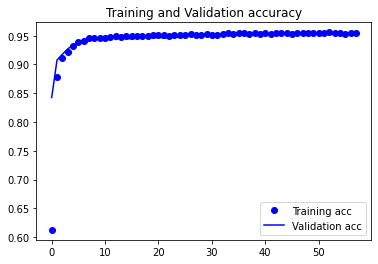

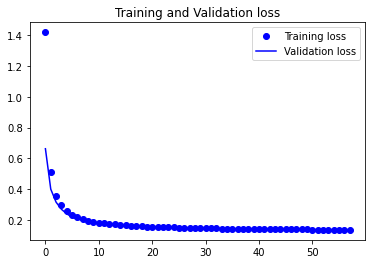

In [29]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label="Training acc")
plt.plot(epochs, val_acc, 'b', label="Validation acc")
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()

plt.show()

##Test it!

In [30]:
y_test_one_hot = keras.utils.to_categorical(y_test, 35)
test_size = X_test.shape[0] - X_test.shape[0] % batch_size

In [31]:
from keras.models import model_from_json
import operator

model_path = "/content/drive/My Drive/KSL-translator/model/"

json_file = open(model_path + 'SLT-model-001-001.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(model_path + "SLT-model-001-001.h5")
print("Loaded model from disk")

Loaded model from disk


In [33]:
model.compile(
   optimizer=optimizers.Adam(lr=learning_rate, decay=decay_rate),
   metrics=['accuracy'],
   loss='categorical_crossentropy'
)

loss_and_metrics = model.evaluate(x=X_test[:test_size,:,:], y=y_test_one_hot[:test_size,:], batch_size=batch_size)

print(loss_and_metrics)

6976/6976 [==============================] - 5s 690us/step
[1.3274937626145302, 0.6989678740501404]


##Save the model!

In [ ]:
model_json = model.to_json()
with open("/content/drive/My Drive/Capstone/model/SLT-model-001.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("/content/drive/My Drive/Capstone/model/SLT-model-001.h5")